In [1]:
%cd ..

/home/ubuntu/dev/pepper/projects/metric_learning_playground


In [2]:
import os.path as osp
from numbers import Number
from copy import deepcopy

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
# %matplotlib widget

In [4]:
from mmcv import Config
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import load_checkpoint

from mmcls.apis import multi_gpu_test, single_gpu_test
from mmcls.datasets import build_dataset, build_dataloader
from mmcls.models import build_classifier

from src import *
from src.apis import single_gpu_metric_test

In [65]:
# configs

method_name = "sphereface"
# method_name = "cosface"
# method_name = "arcface"
# method_name = "circleloss"

model_name = 'lenet'
dataset_name = 'mnist'
work_dir_name = f"{method_name}_{dataset_name}"

cfg_fp = osp.join('configs', model_name, f'{method_name}_{dataset_name}.py')

ckpt_iter = 4000
ckpt_path = osp.join('work_dirs', work_dir_name, f'iter_{ckpt_iter}.pth')

assert osp.exists(cfg_fp)
assert osp.exists(ckpt_path)

# setup variables

cfg = Config.fromfile(cfg_fp)
# print(cfg.pretty_text)

In [66]:
dataset = build_dataset(cfg.data.test, default_args=dict(test_mode=True))

loader_cfg = dict(
    samples_per_gpu=128,
    workers_per_gpu=2,
    num_gpus=1,
    dist=False,
    round_up=True,
)
test_loader_cfg = {
    **loader_cfg,
    "shuffle": False,
    "sampler_cfg": None,
    **cfg.data.get("test_dataloader", {}),
}
data_loader = build_dataloader(dataset, **test_loader_cfg)

In [67]:
model = build_classifier(cfg.model)

In [68]:
def get_features(model, checkpoint_path, data_loader, dataset):
    # load checkpoint
    checkpoint = load_checkpoint(model, checkpoint_path, map_location="cpu")
    
    CLASSES = checkpoint["meta"]["CLASSES"]
    print(CLASSES)
    
    # convert model
    model = MMDataParallel(model, device_ids=[0])
    model.CLASSES = CLASSES

    # get predictions and features
    preds, feats = single_gpu_metric_test(
        model, data_loader,
    )
    
    
    eval_results = dataset.evaluate(
        results=preds,
        metric=["accuracy", "f1_score"],
        metric_options=None,
    )
    for k, v in eval_results.items():
        if isinstance(v, np.ndarray):
            v = [round(out, 2) for out in v.tolist()]
        elif isinstance(v, Number):
            v = round(v, 2)
        else:
            raise ValueError(f"Unsupport metric type: {type(v)}")
        print(f"\n{k} : {v}")
        
    return feats

In [69]:
feats = get_features(model, ckpt_path, data_loader, dataset)

load checkpoint from local path: work_dirs/sphereface_mnist/iter_4000.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 99.37

accuracy_top-5 : 99.92

f1_score : 99.37


In [70]:
import plotly.express as px
import pandas as pd

In [71]:
labels = np.array(dataset.get_gt_labels())
features = np.array(deepcopy(feats))

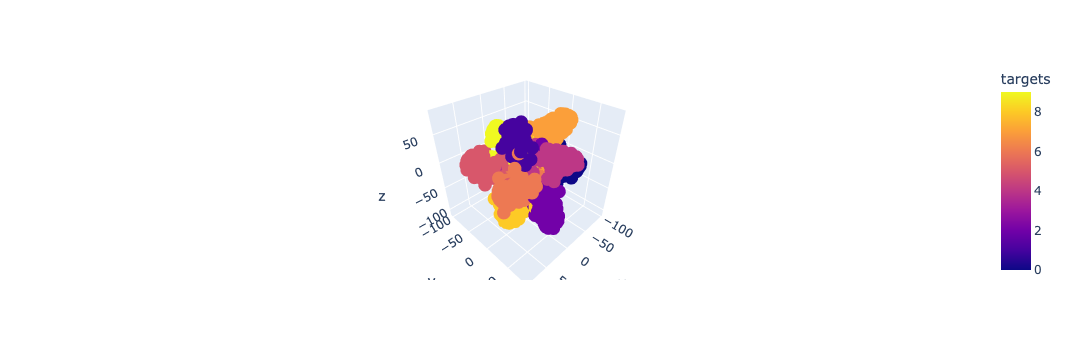

In [72]:
tsne_df = pd.DataFrame(
    np.column_stack((features, labels)),
    columns = ["x","y","z","targets"]
)

fig = px.scatter_3d(tsne_df, x='x', y='y', z='z',
              color='targets')
fig.show()

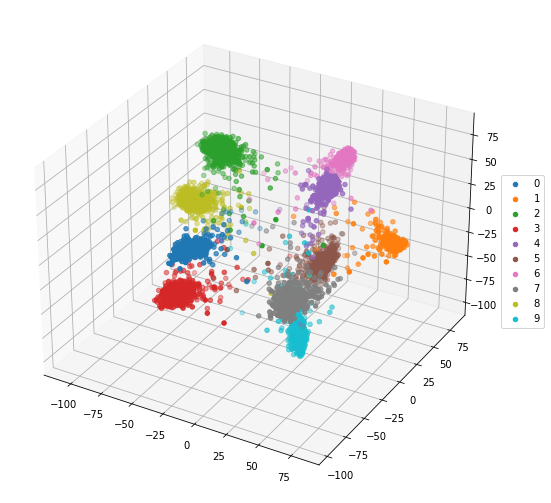

In [73]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = features[labels==i,2].flatten()
    ydata = features[labels==i,0].flatten()
    zdata = features[labels==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

load checkpoint from local path: work_dirs/circleloss_mnist/iter_500.pth
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

accuracy_top-1 : 84.6

accuracy_top-5 : 99.79

f1_score : 80.35


NameError: name 'num_classes' is not defined

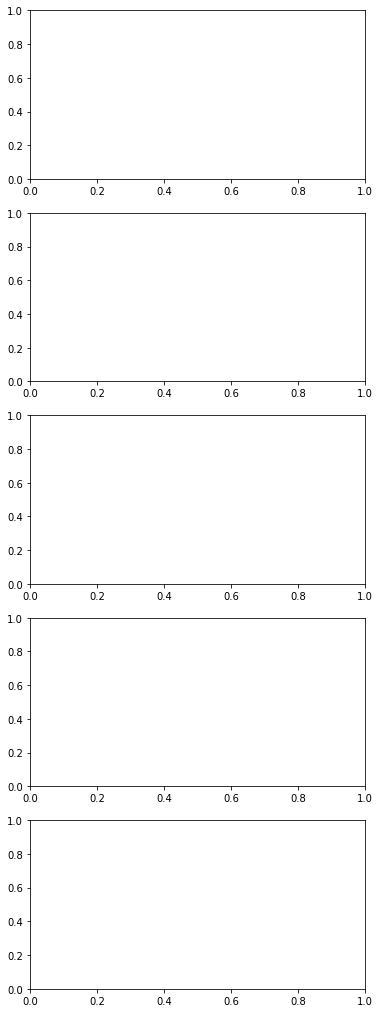

In [50]:
# checkpoints = [2000, 4000, 6000]
checkpoints = [500, 1000, 3000, 5000, 8000]
# plt.gcf().set_dpi(300)

fig, axs = plt.subplots(nrows=len(checkpoints), ncols=1, figsize=(6, 18))

for i, cp in enumerate(checkpoints):
    ckpt_path = osp.join('work_dirs', work_dir_name, f'iter_{cp}.pth')
    assert osp.exists(ckpt_path), ckpt_path
    
    f = get_features(model, ckpt_path, data_loader, dataset)
    features = np.array(deepcopy(f))
    
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
    for label_idx in range(num_classes):
        axs[i].scatter(
            features[labels == label_idx, 0],
            features[labels == label_idx, 1],
            c=colors[label_idx],
            s=1,
        )
    axs[i].legend(
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc="upper right"
    )